In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split

In [8]:
data = fetch_openml('Kuzushiji-MNIST')

In [17]:
X, t = data.data.to_numpy(), data.target.to_numpy()
X = X/255. # accomplishes the scaling
X = X.reshape((70000,28,28))
t = t.astype(np.uint8)

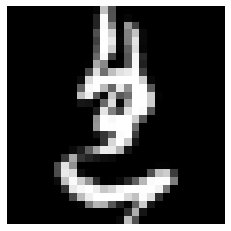

In [24]:
plt.imshow(X[34566], cmap='gray')
plt.axis('off');

In [27]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, 
                                                  test_size = 0.20,
                                                  stratify = t_train)

In [28]:
bottleneck = 100

In [29]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(800, use_bias=False),
    keras.layers.Dense(200, use_bias=False),
    keras.layers.Dense(bottleneck, use_bias=False)
])

decoder = keras.models.Sequential([
    keras.layers.Dense(200, use_bias=False),
    keras.layers.Dense(800, use_bias=False),
    keras.layers.Dense(28*28,use_bias=False),
    keras.layers.Reshape([28, 28])
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss=keras.losses.mean_squared_error, 
                    optimizer=keras.optimizers.SGD(learning_rate=0.1))